# 基于每日更新的数据，预测美国的最新新冠感染人数

> 先把数据更新到data, 然后每天刷新数据源。<br/>
> 详见```SourceDataObtain.py```

## 数据预处理
> 数据集进行归一化处理，首先设置数据集为浮点类型，然后取数据集最大和最小项差值为放缩尺度，对每一个数据集数值进行归一化。

对源数据进行读取

In [5]:
import torch
import utils
import datetime
import numpy as np
import pandas as pd
import csv

In [10]:
t_list = []
with open('data/covid19_time_series.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[2] == 'Lat' or row[1] == 'US':
            t_list.append(row)
print(t_list)

[['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20', '4/19/

In [11]:
df = pd.DataFrame(t_list[1:],columns=t_list[0])
print(df)

  Province/State Country/Region   Lat    Long 1/22/20 1/23/20 1/24/20 1/25/20  \
0                            US  40.0  -100.0       1       1       2       2   

  1/26/20 1/27/20  ...   7/18/21   7/19/21   7/20/21   7/21/21   7/22/21  \
0       5       5  ...  34079960  34132071  34174774  34226806  34281864   

    7/23/21   7/24/21   7/25/21   7/26/21   7/27/21  
0  34400655  34428050  34443761  34533179  34603919  

[1 rows x 557 columns]


In [12]:
# 去除不必要数据
del df['Lat']
del df['Long']
del df['Province/State']
del df['Country/Region']
print(df)

  1/22/20 1/23/20 1/24/20 1/25/20 1/26/20 1/27/20 1/28/20 1/29/20 1/30/20  \
0       1       1       2       2       5       5       5       6       6   

  1/31/20  ...   7/18/21   7/19/21   7/20/21   7/21/21   7/22/21   7/23/21  \
0       8  ...  34079960  34132071  34174774  34226806  34281864  34400655   

    7/24/21   7/25/21   7/26/21   7/27/21  
0  34428050  34443761  34533179  34603919  

[1 rows x 553 columns]


In [13]:
confirmed_data_list = []
for row in df.iterrows():
    confirmed_data_list = [int(row[1][i]) for i in range(len(row[1])) if i > 1]
# 获取每日新增
confirmed_data_list = [confirmed_data_list[i+1]-confirmed_data_list[i] for i in range(len(confirmed_data_list)-1)]

confirmed_data_list = np.array(confirmed_data_list)
print(confirmed_data_list)

[     0      3      0      0      1      0      2      0      0      3
      0      0      1      0      0      0      0      1      0      1
      0      0      0      0      0      0      0      2      0      0
      0      0      0      1      0      8      7     23     19     33
     77     53    166    116     75    188    365    439    633    759
    234   1467   1833   2657   4494   6367   5995   8873  11238  10619
  12082  17856  18690  19630  18899  22075  26314  32286  32222  32307
  32386  29895  31390  30779  31235  35942  34403  29083  27256  26939
  28818  25408  30002  33066  27907  26062  29820  25926  28911  33612
  32327  30380  26488  23715  24575  26459  29205  34907  27348  24321
  24068  24528  24569  27429  26830  25176  18805  19298  22927  20433
  26817  24733  24135  18388  22389  20979  22725  25769  23649  21099
  20077  18662  19663  18551  22320  24478  23632  18983  17414  21502
  19857  21658  25403  21142  17928  17616  18383  21111  23166  24828
  2521

绘制```rolling mean, rolling std, 即rolling statistic```统计图
> rolling statistic 是每个时间段内的平均的数据均值和标准差情况

In [14]:
import matplotlib.pyplot as plt
def test_stationary(time_series_data):
    #这里以14天为一个窗口，每一个时间t的值由它前面14天（包括自己）的均值代替，标准差同理。
    # 老版本 rolmean = pd.rolling_mean(time_series_data,window=14)
    time_series_data = pd.DataFrame(time_series_data)
    rolmean = time_series_data.rolling(14).mean()
    # 老版本 rolstd = pd.rolling_std(time_series_data, window=14)
    rolstd = time_series_data.rolling(14).std()
    #plot rolling statistics:
    fig = plt.figure()
    fig.add_subplot()
    # orig = plt.plot(time_series_data, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')

    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

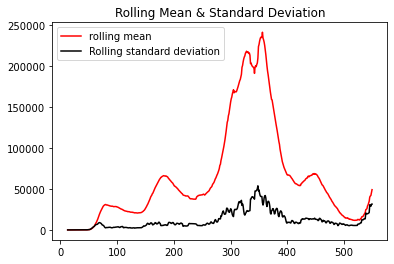

In [15]:
test_stationary(confirmed_data_list)

In [16]:
max_v = np.max(confirmed_data_list)
min_v = np.min(confirmed_data_list)
scalar = max_v - min_v
confirmed_data_list = list(map(lambda x: x/scalar, confirmed_data_list))
print(confirmed_data_list)

[0.0, 9.984623679533519e-06, 0.0, 0.0, 3.3282078931778395e-06, 0.0, 6.656415786355679e-06, 0.0, 0.0, 9.984623679533519e-06, 0.0, 0.0, 3.3282078931778395e-06, 0.0, 0.0, 0.0, 0.0, 3.3282078931778395e-06, 0.0, 3.3282078931778395e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.656415786355679e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3282078931778395e-06, 0.0, 2.6625663145422716e-05, 2.3297455252244876e-05, 7.654878154309031e-05, 6.323594997037895e-05, 0.0001098308604748687, 0.00025627200777469364, 0.00017639501833842549, 0.0005524825102675214, 0.0003860721156086294, 0.000249615591988338, 0.0006257030839174338, 0.0012147958810099114, 0.0014610832651050715, 0.0021067555963815723, 0.00252610979092198, 0.0007788006470036145, 0.0048824809792918904, 0.0061006050681949794, 0.008843048372173519, 0.014956966271941211, 0.021190699655863305, 0.01995260631960115, 0.02953118863616697, 0.03740240030353256, 0.03534223961765548, 0.04021140776537466, 0.0594284801405835, 0.062204205523493816, 0.06533272094308099, 0.062899

## 创建数据集
> X 是一串固定长度序列的集合<br/>
> Y 是对应固定长度序列的输出<br/>
> ```look_back```指的是取前```look_back```天的数据作为特征。

In [51]:
def create_dataset(dataset, look_back=14):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 创建好输入输出
data_X, data_Y = create_dataset(confirmed_data_list)
print(data_X)
print(data_Y)

[[0.00000000e+00 9.98462368e-06 0.00000000e+00 ... 0.00000000e+00
  3.32820789e-06 0.00000000e+00]
 [9.98462368e-06 0.00000000e+00 0.00000000e+00 ... 3.32820789e-06
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.32820789e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.05150735e-02 1.16530543e-01 8.79445654e-02 ... 1.83244470e-01
  3.95361144e-01 9.11762552e-02]
 [1.16530543e-01 8.79445654e-02 1.05986780e-01 ... 3.95361144e-01
  9.11762552e-02 5.22894742e-02]
 [8.79445654e-02 1.05986780e-01 9.45610427e-02 ... 9.11762552e-02
  5.22894742e-02 2.97601693e-01]]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.32820789e-06
 0.00000000e+00 3.32820789e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.65641579e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.32820789e-06
 0.00000000e+00 2.66256631e-05 2.32974553e-05 7.65487815e-05
 6.32359500e-05 1.09830860e-04 2.5

## 创建训练集与测试集
> 数据集的训练与测试比例为 7:3<br/>
> 前70%作为训练集，后30%作为测试集

In [52]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

## 设置LSTM模型数据类型和形状
把train_X改造为一个```ndarray```, 里面每个元素长度为14, 也就是说有前面14天的数据。

In [53]:
train_X = train_X.reshape(-1, 1, 14)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 14)
test_Y = test_Y.reshape(-1, 1, 1)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_Y)

## 建立LSTM模型
第一层为LSTM神经网络, 第二层为一个全连接层

In [6]:
from torch import nn
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self,input_size=14,hidden_size=4,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

model = lstm(14, 4, 1, 2)

## 建立损失函数和优化器
设置均方误差函数和自适应梯度下降算法

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

## 模型训练

In [14]:
# 开始训练
for e in range(1000):
    var_x = Variable(train_x.to(torch.float32))
    var_y = Variable(train_y.to(torch.float32))
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00321
Epoch: 200, Loss: 0.00229
Epoch: 300, Loss: 0.00207
Epoch: 400, Loss: 0.00190
Epoch: 500, Loss: 0.00176
Epoch: 600, Loss: 0.00163
Epoch: 700, Loss: 0.00148
Epoch: 800, Loss: 0.00132
Epoch: 900, Loss: 0.00116
Epoch: 1000, Loss: 0.00103


## 模型预测

### 全序列数据预测

In [25]:
model = model.eval() # 转换成测试模式

data_X = data_X.reshape(-1, 1, 14)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X.to(torch.float32))
pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
print(pred_test)

[-3.61588597e-03 -1.42335892e-04  8.82253051e-03  9.65777040e-03
  8.64836574e-03  7.28625059e-03  6.17170334e-03  5.43430448e-03
  4.99606133e-03  4.74134088e-03  4.58523631e-03  4.48065996e-03
  4.40460443e-03  4.34738398e-03  4.30560112e-03  4.27386165e-03
  4.24847007e-03  4.22993302e-03  4.21619415e-03  4.20674682e-03
  4.20090556e-03  4.19452786e-03  4.19551134e-03  4.20051813e-03
  4.21464443e-03  4.22826409e-03  4.24256921e-03  4.30017710e-03
  4.33453918e-03  4.43729758e-03  4.51946259e-03  4.47708368e-03
  4.56190109e-03  4.83977795e-03  5.15088439e-03  5.52794337e-03
  5.89165092e-03  5.61687350e-03  6.43083453e-03  8.11570883e-03
  9.71886516e-03  1.27996802e-02  1.68158710e-02  1.94305480e-02
  2.39810050e-02  3.11411917e-02  3.52672637e-02  3.96581590e-02
  4.88691926e-02  5.68427145e-02  6.33051097e-02  6.70532882e-02
  6.86287582e-02  7.95415640e-02  9.96079743e-02  1.08612031e-01
  1.06320351e-01  1.06338292e-01  1.07470930e-01  1.14339083e-01
  1.20728523e-01  1.14883

In [27]:
zero_x = [0 for i in range(14)]
pred_test = np.array(zero_x + list(pred_test))
print(pred_test)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.61588597e-03 -1.42335892e-04
  8.82253051e-03  9.65777040e-03  8.64836574e-03  7.28625059e-03
  6.17170334e-03  5.43430448e-03  4.99606133e-03  4.74134088e-03
  4.58523631e-03  4.48065996e-03  4.40460443e-03  4.34738398e-03
  4.30560112e-03  4.27386165e-03  4.24847007e-03  4.22993302e-03
  4.21619415e-03  4.20674682e-03  4.20090556e-03  4.19452786e-03
  4.19551134e-03  4.20051813e-03  4.21464443e-03  4.22826409e-03
  4.24256921e-03  4.30017710e-03  4.33453918e-03  4.43729758e-03
  4.51946259e-03  4.47708368e-03  4.56190109e-03  4.83977795e-03
  5.15088439e-03  5.52794337e-03  5.89165092e-03  5.61687350e-03
  6.43083453e-03  8.11570883e-03  9.71886516e-03  1.27996802e-02
  1.68158710e-02  1.94305480e-02  2.39810050e-02  3.11411917e-02
  3.52672637e-02  3.96581

### 测试集预测

In [54]:
test_X = torch.from_numpy(test_X)
var_test_data = Variable(test_X.to(torch.float32))
var_test_y = Variable(test_y.to(torch.float32))
pred_test_data = model(var_test_data)
test_loss = criterion(pred_test_data,var_test_y)
print('Test loss is {:.5f}'.format(test_loss.item()))
pred_test_data = pred_test_data.view(-1).data.numpy()

Test loss is 0.00156


### 用最近14天的数据预测今天的新增人数

In [17]:
# 用recent_data中的最后14位预测接下来1天的数据
recent_data = np.array([confirmed_data_list[i] for i in range(len(confirmed_data_list)-14,len(confirmed_data_list))])
recent_data = recent_data.reshape(-1, 1, 14)
recent_data = torch.from_numpy(recent_data)
var_recent_data = Variable(recent_data.to(torch.float32))
# 开始预测
pre_recent_data = model(var_recent_data)
# 预测结果由tensor转numpy
pre_recent_data = pre_recent_data.detach().numpy()
print(pre_recent_data)

[[[0.24642801]]]


结果转译，也就是转为具体人数

In [18]:
result = pre_recent_data[0][0][0]
result = result * scalar + min_v
# 四舍五入
result = int(result + 0.5)
print(result)

74042


为了方便后续的预测，做一个预测函数

In [19]:
def predict_latter(days, origin_data):
    temp_data = origin_data[:]
    current_date = utils.get_newly_date()
    day_array = []
    result_array = []
    for j in range(days):
        current_date = current_date + datetime.timedelta(days=1)
        current = np.array([temp_data[i] for i in range(len(temp_data) - 14, len(temp_data))])
        current = current.reshape(-1, 1, 14)
        current = torch.from_numpy(current)
        var_current_data = Variable(current.to(torch.float32))
        # 开始预测
        pre_current_data = model(var_current_data)
        # 预测结果由tensor转numpy
        pre_current_data = pre_current_data.detach().numpy()
        print(pre_current_data)
        today_result = pre_current_data[0][0][0]
        temp_data.append(today_result)
        today_result = today_result * scalar + min_v
        # 四舍五入
        today_result = int(today_result + 0.5)
        day_array.append(str(current_date))
        result_array.append(today_result)
    return day_array, result_array

预测一下接下来5天的数据

In [35]:
next_days, next_days_data = predict_latter(5, confirmed_data_list)
print(next_days)
print(next_days_data)

[[[0.24642801]]]
[[[0.30649292]]]
[[[0.36019188]]]
[[[0.22023024]]]
[[[0.20934641]]]
['2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01']
[74042, 92089, 108224, 66171, 62901]


## 预测序列可视化

### 全序列可视化

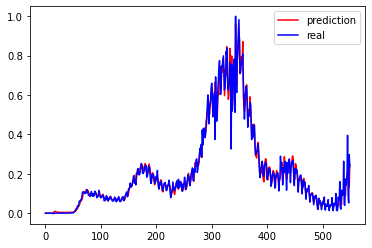

In [28]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(confirmed_data_list, 'b', label='real')
plt.legend(loc='best')

### 预测序列可视化

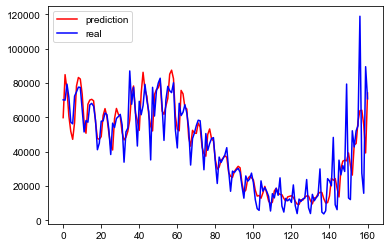

In [32]:
plt.plot([pred_test_data[i] * scalar + min_v for i in range(len(pred_test_data))], 'r', label='prediction')
plt.plot([test_Y[i] * scalar + min_v for i in range(len(test_Y))], 'b', label='real')
plt.legend(loc='best')
plt.show()

### 序列 ```rolling mean``` 可视化

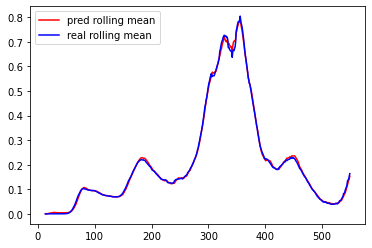

In [29]:
# 上面的这个图像抖动太严重，为了让实验结果更友好，采用可视化rolling mean
origin_dataframe = pd.DataFrame(confirmed_data_list)
rolmean_origin = origin_dataframe.rolling(14).mean()
pred_test_dataframe = pd.DataFrame(pred_test)
rolmean_pre = pred_test_dataframe.rolling(14).mean()
plt.plot(rolmean_pre,'r', label='pred rolling mean')
plt.plot(rolmean_origin, 'b', label='real rolling mean')
plt.legend(loc='best')

接下来5天的新增趋势走向

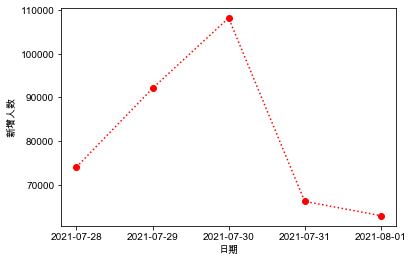

In [36]:
# 解决显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
# 绘图
plt.plot(next_days, next_days_data, c='r', linestyle=':', marker='o')
plt.ylabel('新增人数')
plt.xlabel('日期')
plt.show()

## 模型保存与加载
### 模型保存
> 方法一: 只保存参数。优点有速度快, 占空间少<br/>
> 方法二: 全部保存<br/>

In [28]:
PATH = 'models/COVID_US_LSTM.pt'
# 方法一
torch.save(model.state_dict(),PATH)
# 方法二:
# torch.save(model, PATH)

### 模型加载


In [8]:
PATH = 'models/COVID_US_LSTM.pt'
# 方法一
model = lstm(14, 4, 1, 2)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>